In [46]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                    'machine-learning-databases'
                    '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [47]:
df.shape


(569, 32)

In [48]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_


array(['B', 'M'], dtype=object)

In [49]:
le.transform(['M', 'B'])



array([1, 0])

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=1)


In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# 連結する処理としてスケーリング、主成分分析、ロジスティクス回帰を指定
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f'Test Accuracy: {pipe_lr.score(X_test, y_test)} %')



Test Accuracy: 0.956140350877193 %


In [52]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
# 分割元データ、分割数、乱数生成器の状態を指定し、
# 層化k分割交差検証イテレータを表すStratifiedKFoldクラスのインスタンス化
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
scores = []
"""
イテレータのインデックスと要素をループ処理
    データをモデルに適合
    テストデータの正解率を算出
    リストに正解率を追加
    分割の番号, 0 以上の要素数、正解率を出力
"""
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist : %s, Acc: %.3f' % 
            (k+1, np.bincount(y_train[train]), score))

# 正解率の平均と標準偏差を出力
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


Fold:  1, Class dist : [256 153], Acc: 0.935
Fold:  2, Class dist : [256 153], Acc: 0.935
Fold:  3, Class dist : [256 153], Acc: 0.957
Fold:  4, Class dist : [256 153], Acc: 0.957
Fold:  5, Class dist : [256 153], Acc: 0.935
Fold:  6, Class dist : [257 153], Acc: 0.956
Fold:  7, Class dist : [257 153], Acc: 0.978
Fold:  8, Class dist : [257 153], Acc: 0.933
Fold:  9, Class dist : [257 153], Acc: 0.956
Fold: 10, Class dist : [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


In [53]:
from sklearn.model_selection import cross_val_score
# 交差検証のcross_val_score関数でモデルの正解率を算出
# 推定器estimator, train_data:X, 予測値y, 分割数cv, CPU数 n_jobs
scores = cross_val_score(estimator=pipe_lr,
                            X=X_train, y=y_train,
                            cv=10, n_jobs=1)
# n_jobs=-1でCPUをよしなに
print('CV accuracy scores: %s' % scores)

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

CV accuracy: 0.950 +/- 0.014


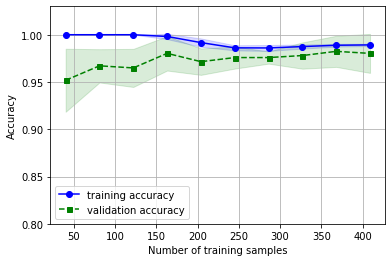

In [54]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1))
# learning_curve関数で交差検証による正解率を算出
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                            cv=10,
                                            n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
            color='blue', marker='o', label='training accuracy')

# fill_between関数で平均±標準偏差の幅を塗りつぶす
# トレーニングデータサイズtrain_sizes, 透明度alpha, カラーblue
plt.fill_between(train_sizes, 
                    train_mean + train_std, 
                    train_mean - train_std,
                    alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='validation accuracy')

plt.fill_between(train_sizes, 
                    test_mean + test_std, 
                    test_mean - test_std,
                    alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.ylim([0.8, 1.03])
plt.show()


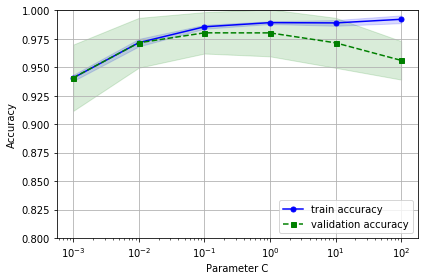

In [55]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# validation_curve関数によりモデルのパラメータを変化させ、
# 交差検証による正解率を算出
# clf_CはLogicticRegressionオブジェクトのパラメータ
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                                X=X_train,
                                                y=y_train,
                                                param_name='logisticregression__C',
                                                param_range=param_range,
                                                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
            color='blue', marker='o',
            markersize=5,
            label='train accuracy')
plt.fill_between(param_range,
                    train_mean + train_std,
                    train_mean - train_std, alpha=0.15,
                    color='blue')

plt.plot(param_range, test_mean,
            color='green', linestyle='--',
            marker='s',
            markersize=5,
            label='validation accuracy')
plt.fill_between(param_range,
                    test_mean + test_std,
                    test_mean - test_std, alpha=0.15,
                    color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                {'svc__C': param_range, 'svc__gamma': param_range,
                    'svc__kernel': ['rbf']}]
# ハイパーパラメータ値のリストparam_gridを指定し、
# グリッドサーチを行う
gs = GridSearchCV(estimator=pipe_svc,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)

print(gs.best_params_)



0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [57]:
clf = gs.best_estimator_

clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % (clf.score(X_test, y_test)))



Test accuracy: 0.974


In [58]:
gs = GridSearchCV(estimator=pipe_svc,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))



CV accuracy: 0.974 +/- 0.015


In [59]:
from sklearn.tree import DecisionTreeClassifier
# ハイパラとして決定木の深さを指定
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                    param_grid=[{'max_depth': [1,2,3,4,5,6,7, None]}],
                    scoring='accuracy',
                    cv=2)

scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring='accuracy',
                        cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))



CV accuracy: 0.934 +/- 0.016


In [60]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[71  1]
 [ 2 40]]


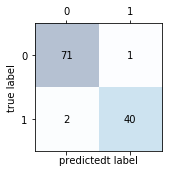

In [61]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predictedt label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()


In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("presicion: %.3f" % (precision_score(y_true=y_test, y_pred=y_pred)))
print("Recall: %.3f" % (recall_score(y_true=y_test, y_pred=y_pred)))
print("F1: %.3f" % (f1_score(y_true=y_test, y_pred=y_pred)))


presicion: 0.976
Recall: 0.952
F1: 0.964


In [63]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                    param_grid=param_grid,
                    scoring=scorer,
                    cv=10,
                    n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.9880219137963148
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


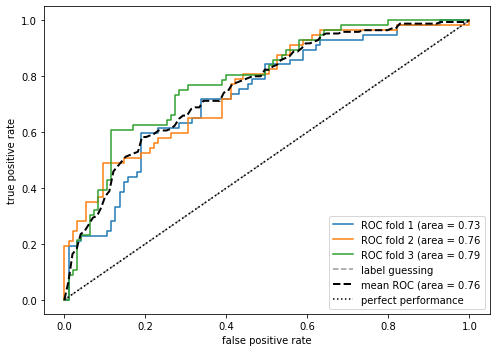

In [64]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', random_state=1, C=100.0))

X_train2 = X_train[:, [4, 14]]
# 層化k分割交差検証イテレータを表すStratifiedKfoldクラス
cv = list(StratifiedKFold(n_splits=3, 
                            random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    # predict_probaで確率を予測、fitメソッドで適合
    probas = pipe_lr.fit(X_train2[train],
                            y_train[train]).predict_proba(X_train2[test])

    # roc_curve関数でROC曲線の性能を計算してプロット
    fpr, tpr, threshold = roc_curve(y_train[test], probas[:, 1], pos_label=1)

    mean_tpr += interp(mean_fpr, fpr, tpr) # FPR(x)とTPR(y)を線形補完
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f' % (i+1, roc_auc))

# 当て推量をプロット
plt.plot([0, 1],
        [0, 1],
        linestyle='--',
        color=(0.6, 0.6, 0.6),
        label='label guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
        label='mean ROC (area = %0.2f' % mean_auc, lw=2)
    
# 完全に予測が正解したときのROC曲線
plt.plot([0, 1],
        [0, 1],
        linestyle=':',
        color='black',
        label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



In [65]:
pre_scorer = make_scorer(score_func=precision_score,
                            pos_label=1,
                            greater_is_better=True,
                            average='micro')


In [66]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100


89.92443324937027

In [67]:
from sklearn.utils import resample
print('Number of class 1 sample before:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb ==1],
                                    y_imb[y_imb ==1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('Number of class 1 sample after:', X_upsampled.shape[0])



Number of class 1 sample before: 40
Number of class 1 sample after: 357


In [68]:
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))


In [69]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100


50.0